In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from maelstrom.kepler import kepler

Read in the light curve, the frequencies, and then the RV data.

In [4]:
kicid = 6780873

data = np.loadtxt(f"data/kic{kicid}_lc.txt")
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

times = times[2500:]
dmmags = dmmags[2500:]

metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)

In [5]:
nu_arr = metadata[::6]
nu_arr

array([ 14.18764154,  13.43633912,   5.39630636])

In [7]:
# load the RV data. They have the same time format (JD-2400000) as the light curve.
rvs = np.loadtxt(f"data/kic{kicid}_JDrv.txt",delimiter=",")

In [8]:
# rvs are in the format [[JD, RV, uncertainty]]
rvs[0]

array([  5.65268571e+04,   8.90000000e+00,   3.00000000e-01])

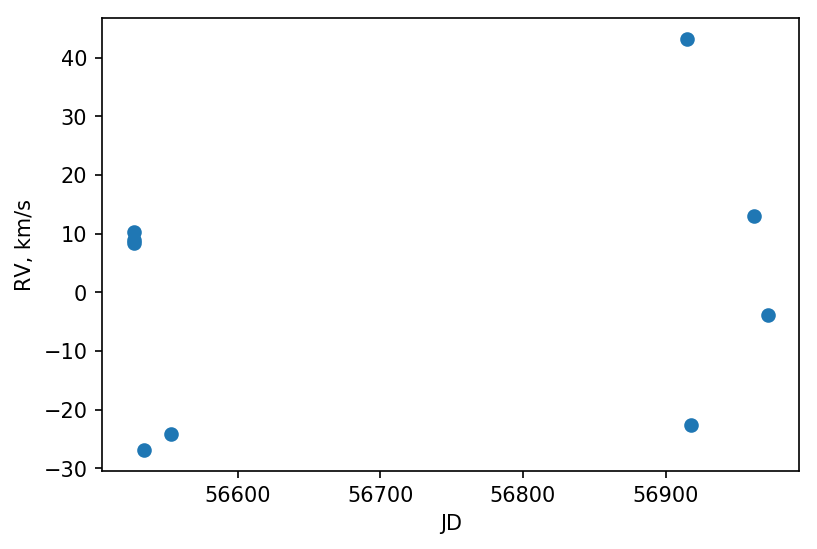

In [9]:
# plot just the RVs for now
plt.errorbar(rvs[:,0],rvs[:,1],rvs[:,2],fmt="o")
plt.xlabel("JD")
plt.ylabel("RV, km/s")
plt.show()

In [10]:
# read in the table of orbits
# oops, our target doesn't have an orbit there, since P < 20 days.
# let's just cheat a bit for now and read in the orbit of this one target as the orbits db

orbits = pd.read_csv(f"data/kic{kicid}_orbit.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] #- tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0
e_param = np.log(e) - np.log(1.0 - e)

In [11]:
sess = tf.InteractiveSession()

In [12]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
a1d_tensor = tf.Variable(a1d, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

rv_time_tensor = tf.placeholder(T, rvs.shape)
rv_tensor = tf.placeholder(T, rvs.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

Calculate the model and likelihood for the time delays

In [16]:
# Here we define how the time delay will be calculated:
tau_tensor = -a1d_tensor * (1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

Now do the same for RVs

In [17]:
# Here we define how the RV will be calculated:
vrad_tensor = -2.0 * np.pi * (a1d_tensor / porb_tensor) * (1/tf.sqrt(1.0 - e_tensor**2)) * (tf.cos(true_anom + varpi_tensor) + e_tensor*tf.cos(varpi_tensor))

# Can we use simple chi^2 fitting here? I feel like we can?


# And the design matrix:
argb_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
Db_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTDb_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTyb_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
Wb_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
modelb_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2b_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2b_tensor += len(times) * log_sigma2_tensor